In [ ]:
import pandas as pd
data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")

NameError: name 'pd' is not defined

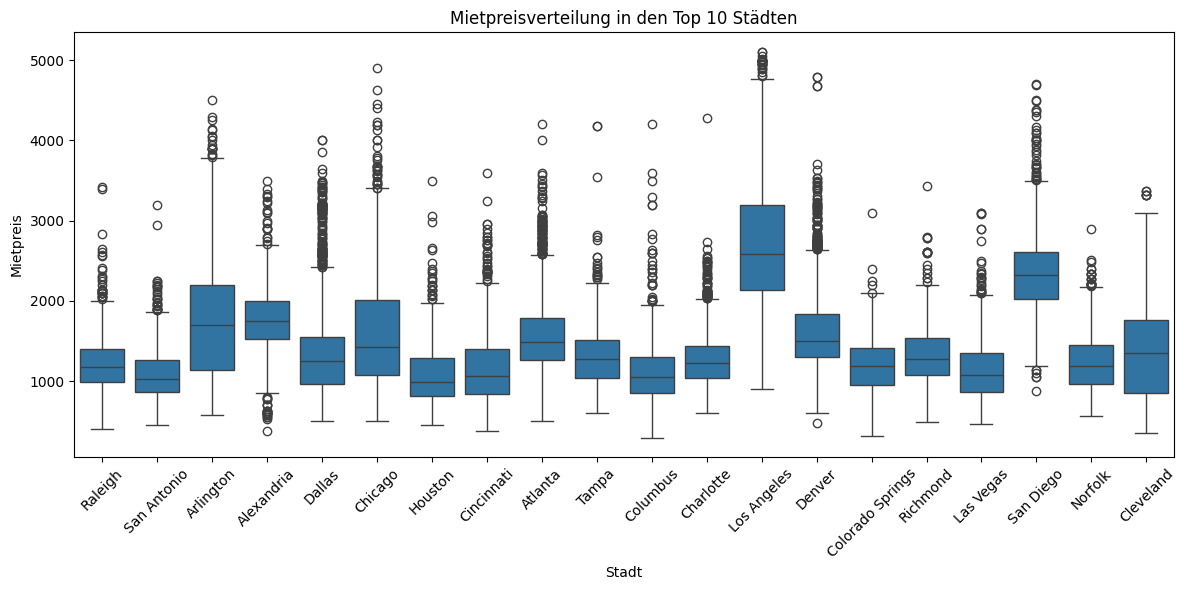

C:\Users\User\AppData\Local\Temp\ipykernel_7628\1948297920.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cityname', y='price', data=data_top, inner='quartile', palette='pastel')


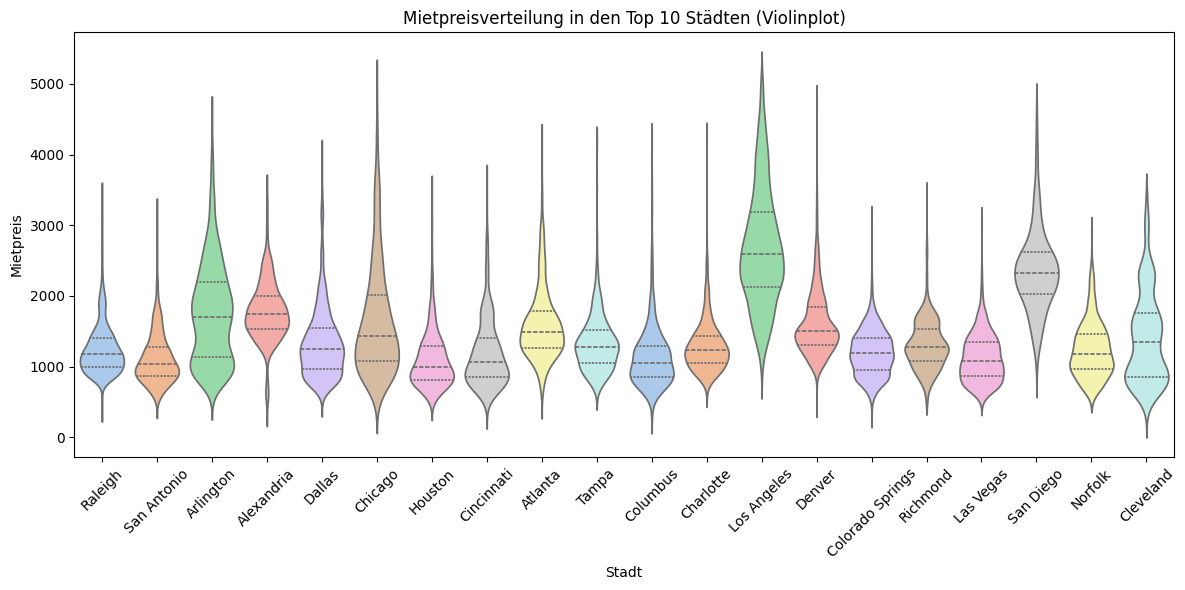

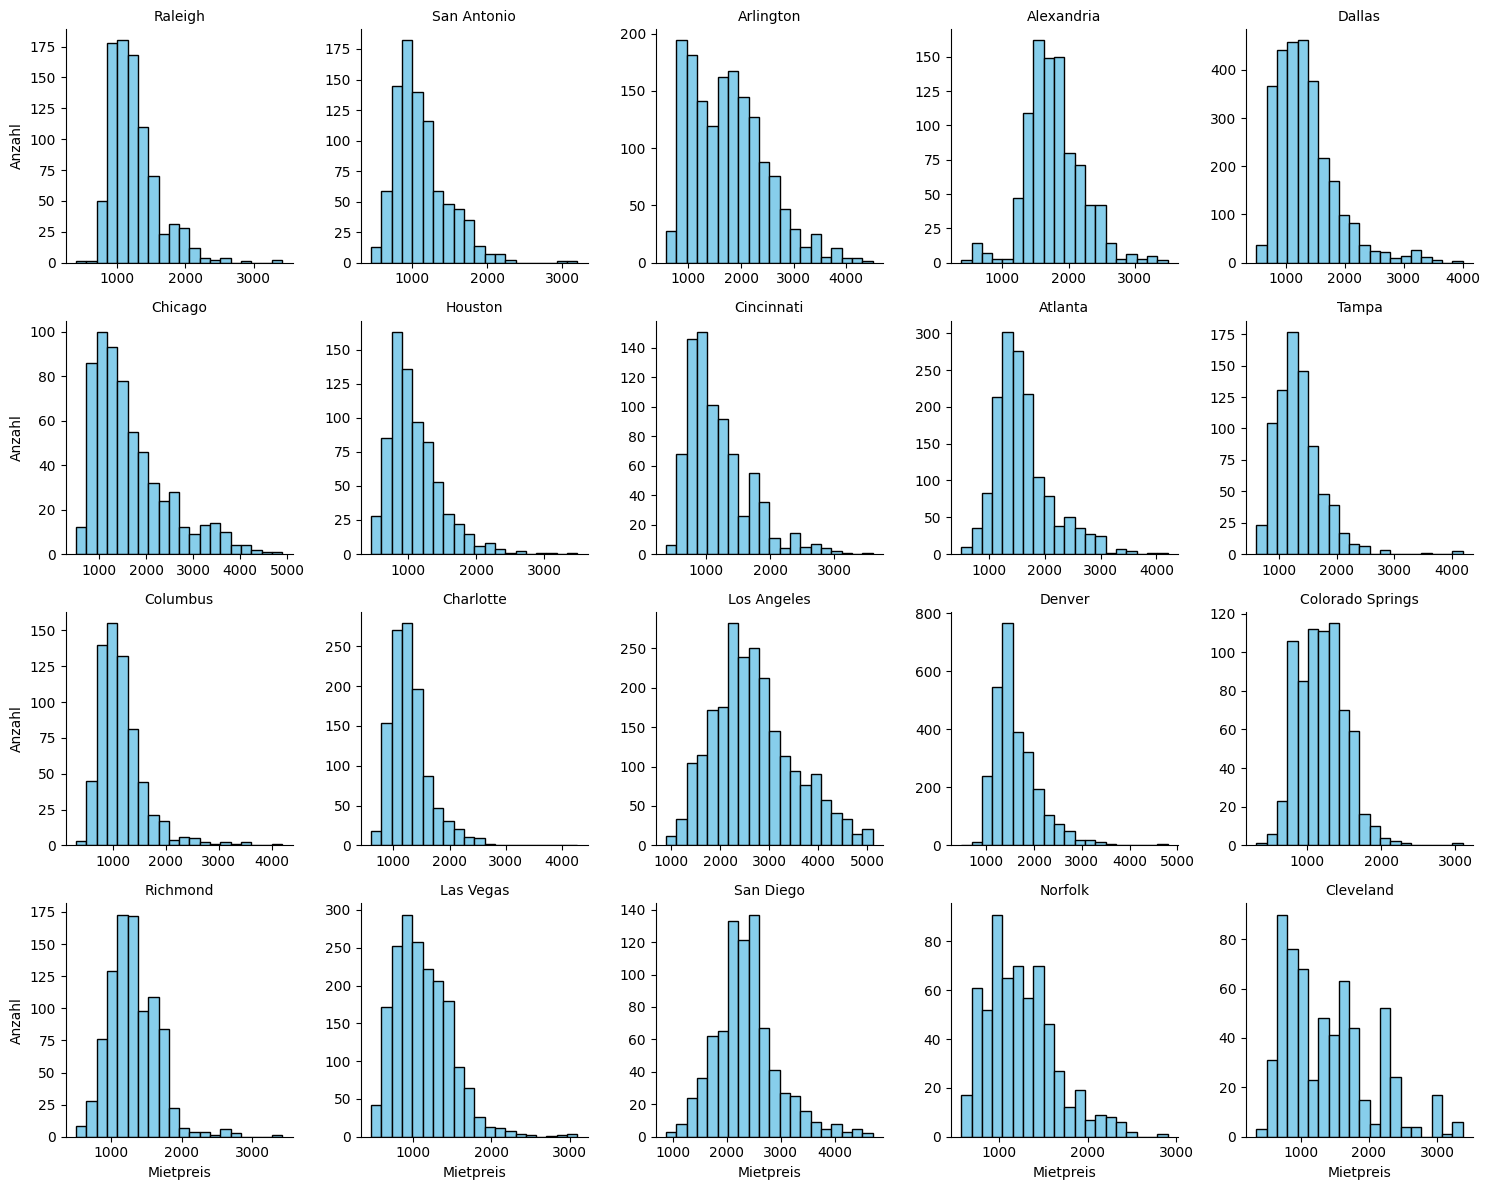

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
top_cities = data['cityname'].value_counts().nlargest(20).index
data_top = data[data['cityname'].isin(top_cities)]

# Plot 1: Boxplot der Preisverteilung pro Stadt
plt.figure(figsize=(12,6))
sns.boxplot(x='cityname', y='price', data=data_top)
plt.xticks(rotation=45)
plt.title('Mietpreisverteilung in den Top 10 Städten')
plt.ylabel('Mietpreis')
plt.xlabel('Stadt')
plt.tight_layout()
plt.show()

# Plot 2: Violinplot (zeigt Dichte besser)
plt.figure(figsize=(12,6))
sns.violinplot(x='cityname', y='price', data=data_top, inner='quartile', palette='pastel')
plt.xticks(rotation=45)
plt.title('Mietpreisverteilung in den Top 10 Städten (Violinplot)')
plt.ylabel('Mietpreis')
plt.xlabel('Stadt')
plt.tight_layout()
plt.show()

# Plot 3: Histogramme pro Stadt (Faceted)
g = sns.FacetGrid(data_top, col="cityname", col_wrap=5, height=3, sharex=False, sharey=False)
g.map(plt.hist, "price", bins=20, color='skyblue', edgecolor='black')
g.set_titles("{col_name}")
g.set_axis_labels("Mietpreis", "Anzahl")
plt.tight_layout()
plt.show()


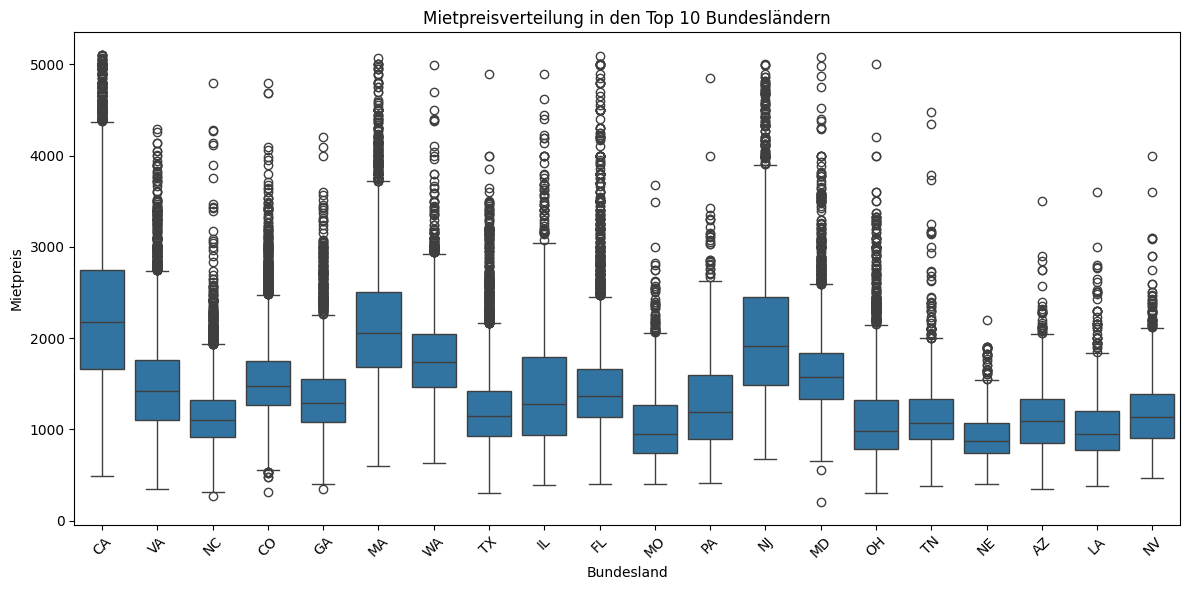

C:\Users\User\AppData\Local\Temp\ipykernel_7628\3304174219.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='state', y='price', data=data_top_states, inner='quartile', palette='pastel')


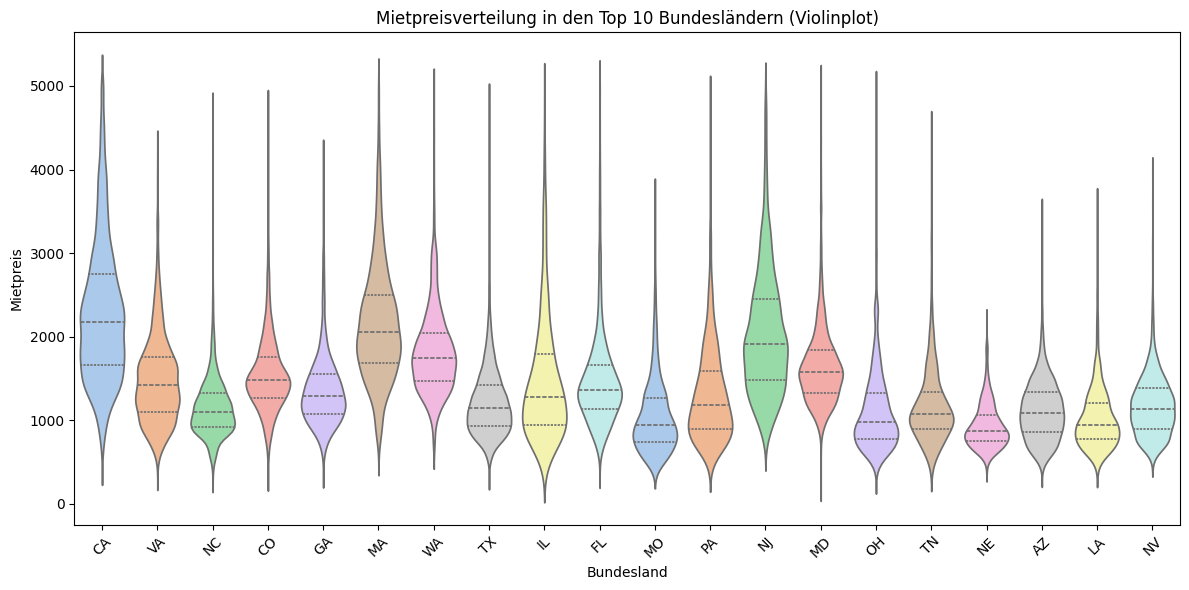

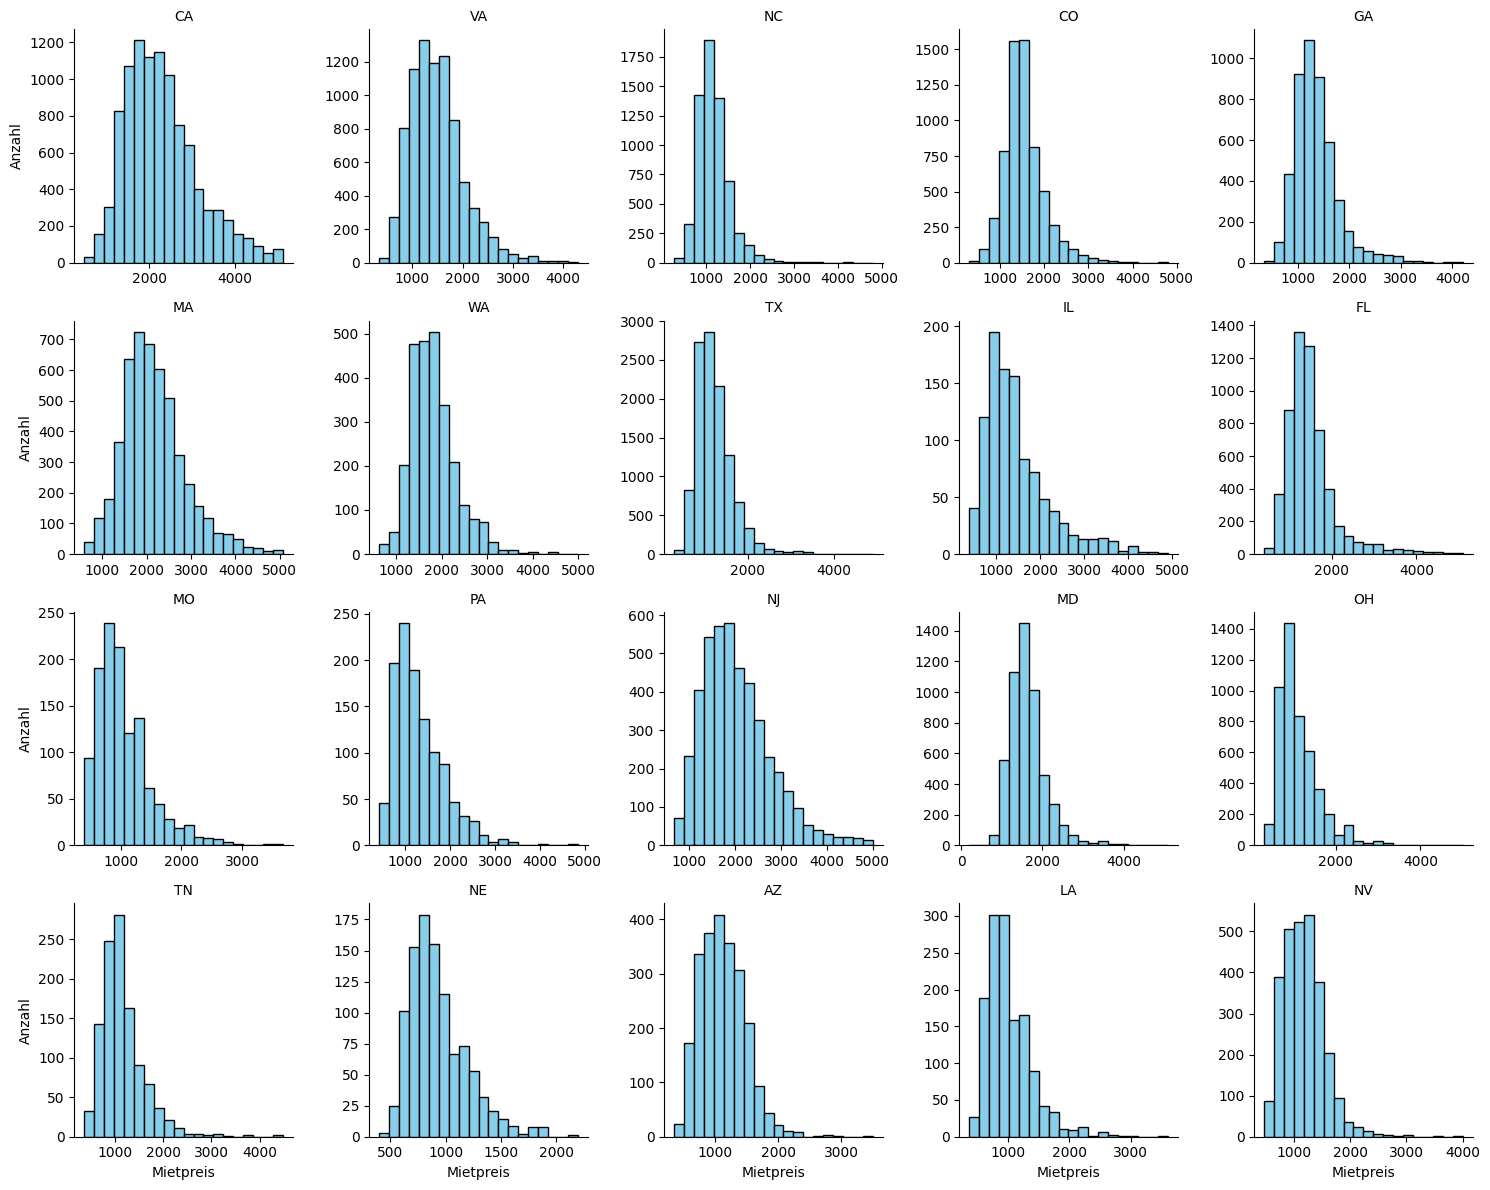

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: nur Top 10 States nach Anzahl der Einträge
top_states = data['state'].value_counts().nlargest(20).index
data_top_states = data[data['state'].isin(top_states)]

# Plot 1: Boxplot der Preisverteilung pro Bundesland
plt.figure(figsize=(12,6))
sns.boxplot(x='state', y='price', data=data_top_states)
plt.xticks(rotation=45)
plt.title('Mietpreisverteilung in den Top 10 Bundesländern')
plt.ylabel('Mietpreis')
plt.xlabel('Bundesland')
plt.tight_layout()
plt.show()

# Plot 2: Violinplot (zeigt Dichte besser)
plt.figure(figsize=(12,6))
sns.violinplot(x='state', y='price', data=data_top_states, inner='quartile', palette='pastel')
plt.xticks(rotation=45)
plt.title('Mietpreisverteilung in den Top 10 Bundesländern (Violinplot)')
plt.ylabel('Mietpreis')
plt.xlabel('Bundesland')
plt.tight_layout()
plt.show()

# Plot 3: Histogramme pro Bundesland (Faceted)
g = sns.FacetGrid(data_top_states, col="state", col_wrap=5, height=3, sharex=False, sharey=False)
g.map(plt.hist, "price", bins=20, color='skyblue', edgecolor='black')
g.set_titles("{col_name}")
g.set_axis_labels("Mietpreis", "Anzahl")
plt.tight_layout()
plt.show()


In [ ]:
X = data
X = X.drop(columns = ["price"])
y = data["price"]
#y = np.log1p(y)  

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


class ClusterRegressor(BaseEstimator, RegressorMixin): #braucht man für clone()
    def __init__(self, base_model, n_clusters=3, random_state=42):
        """
        base_model: sklearn-/xgboost-ähnliches Regressionsmodell
        n_clusters: Anzahl der Cluster
        random_state: Reproduzierbarkeit
        """
        self.base_model = base_model
        self.n_clusters = n_clusters
        self.random_state = random_state

        self.global_model_ = None
        self.city_to_cluster_ = {}
        self.cluster_cities = {}
        self.model_0 = None
        self.model_1 = None 
        self.model_2 = None
        self.scaler = None

    def fit(self, X, y):
        X = pd.DataFrame(X).copy()
        y = pd.Series(y, index=X.index).copy()
        data = pd.concat([X, y.rename('price')], axis=1)
        
        from scipy.stats import skew

        city_features = data.groupby("cityname")["price"].agg(
            #std_dev = np.std,
            std_dev = lambda x: np.std(x) if np.std(x) is not None else 0,
            q90 = lambda x: np.quantile(x, 0.90),
            q10 = lambda x: np.quantile(x, 0.10)
            #skewness = lambda x: skew(x, bias=False)
        )
        #print(city_features)
        
        #KMeans für Städte
        kmeans = KMeans(n_clusters=3, random_state=1)
        city_features['cluster'] = kmeans.fit_predict(city_features)
        self.cluster_cities = {i: city_features[city_features['cluster'] == i].index.tolist() for i in range(3)}
        self.city_to_cluster_ = city_features['cluster'].to_dict()

        clusters = X["cityname"].map(self.city_to_cluster_)

        #print(self.cluster_cities)
        #print(city_features)
        X_enc = X  # Pipeline übernimmt Encoder
        # Scaler
        self.scaler = StandardScaler()
        X_enc = self.scaler.fit_transform(X_enc)

        # Grid Search für alle 3 Clustermodelle
        param_grid = {'alpha': np.logspace(-3, 3, 10)}  # Beispiel für Ridge

        # Cluster 0
        gs0 = GridSearchCV(clone(self.base_model), param_grid, scoring='neg_mean_squared_error', cv=5)
        gs0.fit(X_enc[clusters==0], y[clusters==0])
        self.model_0 = gs0.best_estimator_
        print('best alpha', gs0.best_params_)
        print('Number of data points in Cluster 0: ', (clusters==0).sum())

        # Cluster 1
        gs1 = GridSearchCV(clone(self.base_model), param_grid, scoring='neg_mean_squared_error', cv=5)
        gs1.fit(X_enc[clusters==1], y[clusters==1])
        self.model_1 = gs1.best_estimator_
        print('best alpha', gs1.best_params_)
        print('Number of data points in Cluster 1: ', (clusters==1).sum())

        # Cluster 2
        gs2 = GridSearchCV(clone(self.base_model), param_grid, scoring='neg_mean_squared_error', cv=5)
        gs2.fit(X_enc[clusters==2], y[clusters==2])
        self.model_2 = gs2.best_estimator_
        print('best alpha', gs2.best_params_)
        print('Number of data points in Cluster 2: ', (clusters==2).sum())


        # global fallback model
        gs_global = GridSearchCV(clone(self.base_model), param_grid, scoring='neg_mean_squared_error', cv=5)
        gs_global.fit(X_enc, y)
        self.global_model_ = gs_global.best_estimator_

        print("Fitting abgeschlossen.")
        return self
    def predict(self, X):
        X = pd.DataFrame(X).copy()

        # Stadt → Cluster (NaN für unbekannte Städte)
        clusters = X["cityname"].map(self.city_to_cluster_)
        X = self.scaler.transform(X)
        preds = np.empty(len(X))
        # Cluster 0
        mask = clusters == 0
        if mask.any():
            preds[mask] = self.model_0.predict(X[mask])

        # Cluster 1
        mask = clusters == 1
        if mask.any():
            preds[mask] = self.model_1.predict(X[mask])

        # Cluster 2
        mask = clusters == 2
        if mask.any():
            preds[mask] = self.model_2.predict(X[mask])

        # Fallback: unbekannte Städte
        fallback = clusters.isna()
        if fallback.any():
            preds[fallback] = self.global_model_.predict(X[fallback])

        return preds

In [ ]:

from sklearn.linear_model import Ridge
from Nested_CV_targetEncoding import NestedCVRegressorWithTargetEncoding

#  man muss hier die thresholds auf 0 umstellen in filter_cities
Ridge_clustermodel_cv = NestedCVRegressorWithTargetEncoding(ClusterRegressor(Ridge()), {}, encode_cols=["cityname", "state"], scaler = None)

Ridge_clustermodel_cv.run(X, y, output=True)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
best alpha {'alpha': np.float64(1000.0)}
Number of data points in Cluster 0:  54919
best alpha {'alpha': np.float64(1000.0)}
Number of data points in Cluster 1:  18245
best alpha {'alpha': np.float64(1000.0)}
Number of data points in Cluster 2:  5733
Fitting abgeschlossen.
best alpha {'alpha': np.float64(1000.0)}
Number of data points in Cluster 0:  54919
best alpha {'alpha': np.float64(1000.0)}
Number of data points in Cluster 1:  18245
best alpha {'alpha': np.float64(1000.0)}
Number of data points in Cluster 2:  5733
Fitting abgeschlossen.
Outer Fold 1/5 | Best Params: {} | Fit Time: 49.141s | Outer R²: 0.695 | MSE: 0.055
Fitting 5 folds for each of 1 candidates, totalling 5 fits
best alpha {'alpha': np.float64(0.001)}
Number of data points in Cluster 0:  55854
best alpha {'alpha': np.float64(1000.0)}
Number of data points in Cluster 1:  18164
best alpha {'alpha': np.float64(46.41588833612773)}
Number of data points in Cluste

In [ ]:
number_outer_cv_splits = 5
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['ClusterRegressor'] * number_outer_cv_splits
model_evaluation['R_2'] = Ridge_clustermodel_cv.get_r2_scores()
model_evaluation['MSE'] = Ridge_clustermodel_cv.get_mse_scores()
model_evaluation["runtime"] = Ridge_clustermodel_cv.get_fit_times()
model_evaluation

,Fold,Modell,R_2,MSE,runtime
0,1,Ridge_target_encoding,0.702822,140528.125764,15.433651
1,2,Ridge_target_encoding,0.697801,140151.173589,18.429582
2,3,Ridge_target_encoding,0.693048,142888.461616,9.953673
3,4,Ridge_target_encoding,0.693441,142270.501735,9.997929
4,5,Ridge_target_encoding,0.700839,138927.273048,16.240597


In [ ]:
model_evaluation.to_pickle('benchmarking/ClusterRegressor.pkl')

## Evaluate model by fitting once in outer loop

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=["price"]),
    data["price"],
    test_size=0.2,
    random_state=42
)

In [ ]:
from category_encoders import TargetEncoder

te = TargetEncoder(cols=["cityname", "state"])

X_train_enc = te.fit_transform(X_train, y_train)
X_test_enc = te.transform(X_test)


model = ClusterRegressor(Ridge())
model.fit(X_train_enc, y_train)
preds = model.predict(X_test_enc)
from sklearn.metrics import r2_score
print("R² auf Testdaten:", r2_score(y_test, preds))

C:\Users\User\AppData\Local\Temp\ipykernel_4439060\2775453316.py:35: FutureWarning: The provided callable <function mean at 0x000002401FE16660> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  city_features = data.groupby('cityname')['price'].agg([


best alpha {'alpha': np.float64(215.44346900318823)}
Number of data points in Cluster 0:  20930
best alpha {'alpha': np.float64(46.41588833612773)}
Number of data points in Cluster 1:  10891
best alpha {'alpha': np.float64(2.154434690031882)}
Number of data points in Cluster 2:  47076
Fitting abgeschlossen.
R² auf Testdaten: 0.7050616867104521


In [ ]:
city_mapping = dict(zip(X_train['cityname'], X_train_enc['cityname']))
for key, value in city_mapping.items():
    city_mapping[key] = model.city_to_cluster_[value]

C:\Users\User\AppData\Local\Temp\ipykernel_4439060\3914576017.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="cluster", y="price", data=df_plot, palette="Set2")


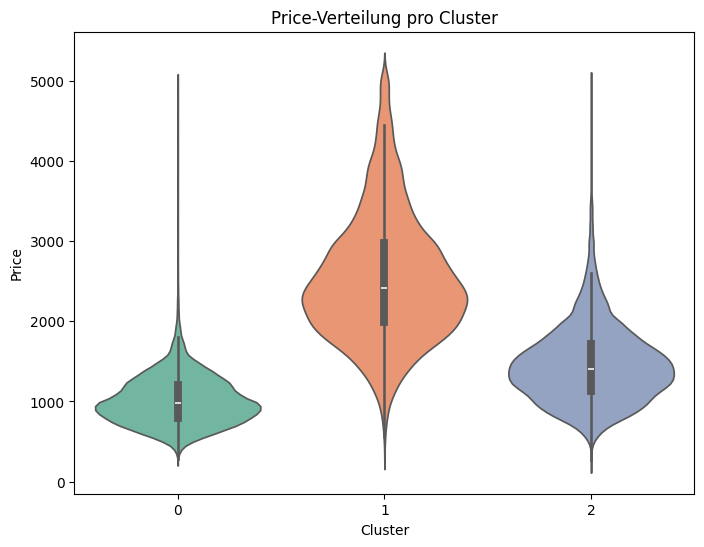

In [ ]:
import pandas as pd

# city_mapping: cityname → cluster
# X_train: enthält cityname
# y_train: Preise

df_plot = pd.DataFrame({
    "cityname": X_train['cityname'],
    "cluster": X_train['cityname'].map(city_mapping),
    "price": y_train.values
})

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.violinplot(x="cluster", y="price", data=df_plot, palette="Set2")
plt.title("Price-Verteilung pro Cluster")
plt.xlabel("Cluster")
plt.ylabel("Price")
plt.show()
